# Multivariate time series forecasting reference with Apache MXNet and Gluon 


This notebook draws heavy inspiration from [link](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/) and tries to recreate the results with `Apache MXNet` and `Gluon`. The aim of this notebook is to show how multivariate timeseries modeling can be done with Apache MXNet and Gluon. Don't forget to review the very handy `reusable` Gluon Regression class.

# Problem
Air pollution forecasting with data recorded at the US embassy in Beijing, China for five years.

# Dataset
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

# Load Dataset and clean it up

In [213]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

## CLEAN DATA

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


```
No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
pm2.5: PM2.5 concentration
DEWP: Dew Point
TEMP: Temperature
PRES: Pressure
cbwd: Combined wind direction
Iws: Cumulated wind speed
Is: Cumulated hours of snow
Ir: Cumulated hours of rain
```

In [244]:
#Lets load the processed dataset

import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


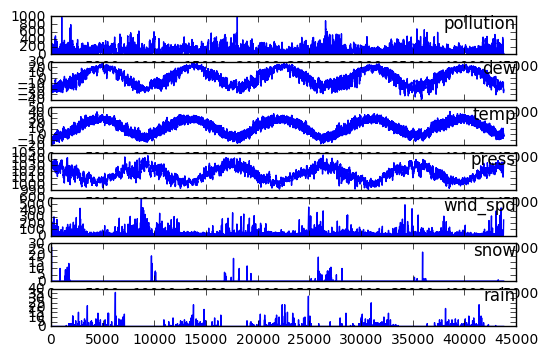

In [245]:
# Get all values
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    plt.subplots_adjust(wspace=2)
    i += 1
plt.show()

### Data Processing

In [246]:
# Encode the labels
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [247]:
# Generate the sequences
# Code inspiration credits: www.machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

import pandas as pd

df = pd.DataFrame(scaled_dataset)
    
cols = []
col_names = []

n_in = 1
n_out = 1
    
n_vars = scaled_dataset.shape[1] # number of columns
print n_vars, scaled_dataset.shape

# input sequence (t-n, ... t-1)
for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    col_names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

# Lets forcecast pollution values
# forecast sequence (t, t+1, ... t+n)
cols.append(df.shift(0))
col_names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
print col_names, len(col_names)

all_values = pd.concat(cols, axis=1)
all_values.columns = col_names
all_values.dropna(inplace=True) #drop NaN
    
# Only forecasting one variable(pollution), so drop the rest
all_values.drop(all_values.columns[range(9,16)], axis=1, inplace=True)
print(all_values.head())

8 (43800, 8)
['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'] 16
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [248]:
# Lets build the sequence values for prediction

seq_len = 1  # sequence length
values = all_values.values
print values.shape

X = values[:,:-1] 
y = values[:,-1] # extract the pollution column

dataX = []; dataY = []
for i in range(0, len(y) - seq_len):
    _x = X[i: i+seq_len]
    _y = y[i: i+seq_len]
    # Lets make the shape convinient for regression
    if seq_len == 1: 
        _y = _y[0]
    dataX.append(_x)
    dataY.append(_y)
    
print dataX[0], dataY[0]

(43799, 9)
[[ 0.12977867  0.35294122  0.24590163  0.52727318  0.66666669  0.00229001
   0.          0.        ]] 0.148893


In [262]:
# split into train and test sets
n_train_hours = 365 * 24

dataX = np.array(dataX)
dataY = np.array(dataY)

#3D [samples, timesteps, features]
train_X, train_y = dataX[n_train_hours:], dataY[n_train_hours:]
test_X, test_y = dataX[:n_train_hours], dataY[:n_train_hours]

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(35038, 1, 8) (35038,) (8760, 1, 8) (8760,)


# Keras model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, nb_epoch=5, 
                    batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# MXNet Symbolic model -- LSTM

In [263]:
import mxnet as mx
batch_size = 72

train_iter = mx.io.NDArrayIter(data=train_X, label=train_y,
                                   data_name="data", label_name="target",
                                   batch_size=batch_size,
                                   shuffle=True)
test_iter = mx.io.NDArrayIter(data=test_X, label=test_y,
                                  data_name="data", label_name="target",
                                  batch_size=batch_size)

In [252]:
import logging
logging.getLogger().setLevel(logging.INFO)

ctx = [mx.cpu(i) for i in range(1)]

# Define the LSTM Neural Network
num_epochs = 25

# Note that when unrolling, if 'merge_outputs' is set to True, 
# the 'outputs' is merged into a single symbol
# In the layout, 'N' represents batch size, 'T' represents sequence length, 
# and 'C' represents the number of dimensions in hidden states.

data = mx.sym.var("data")  # Shape: (N, T, C)
target = mx.sym.var("target")  # Shape: (N, T, C)
data = mx.sym.transpose(data, axes=(1, 0, 2))  # Shape: (T, N, C)

if  isinstance(ctx,list):
    c_ctx = ctx[0]   
else:
    c_ctx = ctx
    
if c_ctx.device_type == 'cpu':
    lstm1 = mx.rnn.LSTMCell(num_hidden=5, prefix="lstm1_")
    lstm2 = mx.rnn.LSTMCell(num_hidden=10, prefix="lstm2_")
else:
    # FusedRNNCell
    lstm1 = mx.rnn.FusedRNNCell(num_hidden=5, mode="lstm", prefix="lstm1_")
    lstm2 = mx.rnn.FusedRNNCell(num_hidden=10, mode="lstm", prefix="lstm2_",
                                    get_next_state=True)

L1, L1_states = lstm1.unroll(length=seq_len, inputs=data, 
                             merge_outputs=True,
                             layout="TNC")  # Shape: (T, N, 5)

L1 = mx.sym.Dropout(L1, p=0.2)  # Shape: (T, N, 5)

L2, L2_states = lstm2.unroll(length=seq_len, inputs=L1, 
                            merge_outputs=True,
                            layout="TNC")  # Shape: (T, N, 10)

L2 = mx.sym.reshape(L2_states[0], shape=(-1, 0), reverse=True)  # Shape: (T * N, 10)
pred = mx.sym.FullyConnected(L2, num_hidden=1, name="pred")
pred = mx.sym.LinearRegressionOutput(data=pred, label=target)

model = mx.mod.Module(symbol=pred, data_names=['data'], 
                    label_names=['target'], context=ctx)

model.fit(train_data=train_iter, eval_data=test_iter,
            initializer=mx.init.Xavier(rnd_type="gaussian", magnitude=1),
            optimizer="adam",
            optimizer_params={"learning_rate": 1E-3},
            batch_end_callback=mx.callback.Speedometer(batch_size, 100),
            eval_metric="mae", num_epoch=num_epochs)

INFO:root:Epoch[0] Batch [100]	Speed: 42700.56 samples/sec	mae=0.068433
INFO:root:Epoch[0] Batch [200]	Speed: 45789.55 samples/sec	mae=0.068445
INFO:root:Epoch[0] Batch [300]	Speed: 46326.42 samples/sec	mae=0.063922
INFO:root:Epoch[0] Batch [400]	Speed: 48871.53 samples/sec	mae=0.051650
INFO:root:Epoch[0] Train-mae=0.038154
INFO:root:Epoch[0] Time cost=0.789
INFO:root:Epoch[0] Validation-mae=0.030409
INFO:root:Epoch[1] Batch [100]	Speed: 38768.89 samples/sec	mae=0.031156
INFO:root:Epoch[1] Batch [200]	Speed: 29241.53 samples/sec	mae=0.027498
INFO:root:Epoch[1] Batch [300]	Speed: 29126.58 samples/sec	mae=0.025719
INFO:root:Epoch[1] Batch [400]	Speed: 32334.42 samples/sec	mae=0.023956
INFO:root:Epoch[1] Train-mae=0.023457
INFO:root:Epoch[1] Time cost=1.110
INFO:root:Epoch[1] Validation-mae=0.018496
INFO:root:Epoch[2] Batch [100]	Speed: 36878.05 samples/sec	mae=0.023438
INFO:root:Epoch[2] Batch [200]	Speed: 26699.70 samples/sec	mae=0.023388
INFO:root:Epoch[2] Batch [300]	Speed: 42455.10 s

### Lets do some predictions

In [253]:
import math
from sklearn.metrics import mean_squared_error

# Prediction
yhat = model.predict(test_iter).asnumpy()
print np.mean((yhat - test_y))

print yhat.shape, test_X.shape, test_X[:, 1:].shape

p_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
p_test_X.shape

inv_yhat = np.concatenate((yhat, p_test_X[:, 1:]), axis=1)
print inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# scale back
scaled_test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((scaled_test_y, p_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

-0.00490275
(8760, 1) (8760, 1, 8) (8760, 0, 8)
(8760, 8)
Test RMSE: 31.751


In [211]:
print "actual   ", inv_y[:5]
print "predicted", [round(v,1) for v in inv_yhat[:5]]

actual    [ 148.  159.  181.  138.  109.]
predicted [127.7, 145.7, 157.7, 180.0, 139.6]


# Multi Layer Perceptron baseline

In [266]:
#MLP
num_epochs = 10
data = mx.sym.Variable('data')
target = mx.sym.var("target")
data = mx.sym.Flatten(data=data)
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=32)
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden=1)
mlp = mx.sym.LinearRegressionOutput(data=fc2, label=target)

mlp_model = mx.mod.Module(symbol=mlp, data_names=['data'], 
                    label_names=['target'], context=ctx)

mlp_model.fit(train_data=train_iter, eval_data=test_iter,
            initializer=mx.init.Xavier(rnd_type="gaussian", magnitude=1),
            optimizer="adam",
            optimizer_params={"learning_rate": 1E-3},
            batch_end_callback=mx.callback.Speedometer(batch_size, 100),
            eval_metric="mae", num_epoch=num_epochs)

INFO:root:Epoch[0] Batch [100]	Speed: 54128.39 samples/sec	mae=0.099886
INFO:root:Epoch[0] Batch [200]	Speed: 53993.20 samples/sec	mae=0.040477
INFO:root:Epoch[0] Batch [300]	Speed: 68374.86 samples/sec	mae=0.022522
INFO:root:Epoch[0] Batch [400]	Speed: 66013.77 samples/sec	mae=0.017587
INFO:root:Epoch[0] Train-mae=0.017038
INFO:root:Epoch[0] Time cost=0.579
INFO:root:Epoch[0] Validation-mae=0.017052
INFO:root:Epoch[1] Batch [100]	Speed: 47257.47 samples/sec	mae=0.016468
INFO:root:Epoch[1] Batch [200]	Speed: 71434.29 samples/sec	mae=0.015770
INFO:root:Epoch[1] Batch [300]	Speed: 66885.17 samples/sec	mae=0.015061
INFO:root:Epoch[1] Batch [400]	Speed: 69751.84 samples/sec	mae=0.014963
INFO:root:Epoch[1] Train-mae=0.015260
INFO:root:Epoch[1] Time cost=0.591
INFO:root:Epoch[1] Validation-mae=0.015513
INFO:root:Epoch[2] Batch [100]	Speed: 45073.86 samples/sec	mae=0.015185
INFO:root:Epoch[2] Batch [200]	Speed: 62771.36 samples/sec	mae=0.014842
INFO:root:Epoch[2] Batch [300]	Speed: 65685.67 s

In [268]:
# Prediction

yhat = mlp_model.predict(test_iter).asnumpy()
print len(yhat), yhat[0]
print np.mean((yhat - test_y))

print yhat.shape, test_X.shape, test_X[:, 1:].shape

p_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print p_test_X.shape

inv_yhat = np.concatenate((yhat, p_test_X[:, 1:]), axis=1)
print inv_yhat.shape, type(inv_yhat)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# scale back
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, p_test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

8760 [ 0.13542168]
0.00219827
(8760, 1) (8760, 1, 8) (8760, 0, 8)
(8760, 8)
(8760, 8) <type 'numpy.ndarray'>
Test RMSE: 30.499


MLP for this use case sort of does the trick, We'll need to find the right params for LSTM, I'll leave that as a fun exercise to the reader

In [310]:
# Plot accuracy
import matplotlib.pyplot as plt
import numpy as np
import re

def show_plot(log_tr, log_val):
    idx = np.arange(len(log_tr))

    plt.figure(figsize=(8, 6))
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.plot(idx, log_tr, 'o', linestyle='-', color="r",
             label="Train loss")
    if log_val is not None:
        plt.plot(idx, log_val, 'o', linestyle='-', color="b",
             label="Val loss")
    plt.legend()
    plt.show()    

def plot_mxnet_curves(log_output, metric='accuracy'):
    TR_RE = re.compile('.*?]\sTrain-%s=([\d\.]+)' % metric)
    VA_RE = re.compile('.*?]\sValidation-%s=([\d\.]+)' % metric)
    
    log_tr = [float(x) for x in TR_RE.findall(log_output)]
    log_val = [float(x) for x in VA_RE.findall(log_output)]
    show_plot(log_tr, log_val)

# Gluon Code

In [303]:
import mxnet as mx
import numpy as np
import math

from mxnet import nd, autograd
from sklearn.metrics import mean_squared_error


def get_data(batch, iter_type):
    ''' get data and label from the iterator/dataloader '''
    if iter_type == 'mxiter':
        X_train = batch.data[0].as_in_context(ctx)
        Y_train = batch.label[0].as_in_context(ctx)
    else:
        X_train = batch[0].as_in_context(ctx)
        Y_train = batch[1].as_in_context(ctx)

    return X_train, Y_train
    
class BaseRNNRegressor(mx.gluon.Block):
    def __init__(self, ctx):
        super(BaseRNNRegressor, self).__init__()
        self.ctx = ctx
        self.rnn = None
        self.rnn_size = None
        
    #@override 
    def build_model(self, rnn_type='lstm', rnn_size=128, n_layer=1, n_out=1):
        self.rnn_size = rnn_size
        self.n_layer = n_layer
        self.net = mx.gluon.rnn.LSTM(rnn_size, n_layer, 'NTC')
        self.output = mx.gluon.nn.Dense(n_out)

    #@override 
    def forward(self, inp, hidden):
        rnn_out, hidden = self.net(inp, hidden)
        #simplify
        logits = self.output(rnn_out.reshape((-1, self.rnn_size)))
        return logits, hidden
        
    def detach(self, arrs):
        return [arr.detach() for arr in arrs]

    def compile_model(self, optimizer='adam', lr=1E-3):
        self.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        self.loss = mx.gluon.loss.L1Loss()
        self.optimizer = mx.gluon.Trainer(self.collect_params(), 
                                    optimizer, {'learning_rate': lr})


    def evaluate_accuracy(self, data_iterator, metric='mae', iter_type='mxiter'):
        met = mx.metric.MAE()
        for i, batch in enumerate(data_iterator):
            data, label = get_data(batch, iter_type)
            preds = self.net(data)
            met.update(labels=label, preds=preds)
        return met.get()
    
    def fit(self, train_data, test_data, epochs):
        moving_loss = 0.
        train_loss = []
        val_loss = []
        iter_type = 'numpy'
        
        # Can take MX NDArrayIter, or DataLoader
        if isinstance(train_data, mx.io.NDArrayIter):
            train_iter = train_data
            #total_batches = train_iter.num_data // train_iter.batch_size
            test_iter = test_data
            iter_type = 'mxiter'

        elif isinstance(train_data, list):
            if isinstance(train_data[0], np.ndarray) and isinstance(train_data[1], np.ndarray):
                X, y = train_data[0], train_data[1]
                #print type(test_data[0])
                #if isinstance(test_data[0], np.ndarray):
                #    raise ValueError("need test array to be numpy array")
                tX, ty = test_data[0], test_data[1]
                train_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y), 
                                    batch_size=batch_size, shuffle=True, last_batch='discard')
                test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=batch_size, shuffle=False, last_batch='discard')
                #total_batches = len(X) // batch_size
        else:
            raise "pass mxnet ndarray or numpy array"

        print "data type:", type(train_data), type(test_data), iter_type

        init_state = mx.nd.zeros((1, batch_size, self.rnn_size), ctx)
        hidden = [init_state] * 2
        
        for e in range(epochs):
            if isinstance(train_iter, mx.io.NDArrayIter): train_iter.reset()
            yhat = []
            for i, batch in enumerate(train_iter):
                data, label = get_data(batch, iter_type)
                with autograd.record(train_mode=True):
                    Y_pred, hidden = self.forward(data, hidden)
                    hidden = self.detach(hidden)
                    loss = self.loss(Y_pred, label) 
                    yhat.extend(Y_pred)
                loss.backward()                                        
                self.optimizer.step(batch_size)

                if i == 0:
                    moving_loss = nd.mean(loss).asscalar()
                else:
                    moving_loss = .99 * moving_loss + .01 * mx.nd.mean(loss).asscalar()
            train_loss.append(moving_loss)
            # TODO: add prediction?
            
            test_err = self.evaluate_accuracy(test_iter, iter_type=iter_type)
            val_loss.append(test_err[1])
            print("Epoch %s. Loss: %.10f Test MAE: %s" % (e, moving_loss, test_err))
        return train_loss, val_loss

In [304]:
ctx = mx.cpu()
model = BaseRNNRegressor(ctx)
model.build_model('lstm', rnn_size=seq_len, n_layer=1, n_out=1)
model.compile_model(optimizer='adam')
t_loss, v_loss = model.fit([train_X, train_y], [test_X, test_y], epochs=10)

data type: <type 'list'> <type 'list'> numpy
Epoch 0. Loss: 0.0430312322 Test MAE: ('mae', 0.12320409051610633)
Epoch 1. Loss: 0.0212265480 Test MAE: ('mae', 0.13827456228630142)
Epoch 2. Loss: 0.0149335518 Test MAE: ('mae', 0.14551130130542703)
Epoch 3. Loss: 0.0138093784 Test MAE: ('mae', 0.15244989452870278)
Epoch 4. Loss: 0.0135432033 Test MAE: ('mae', 0.15450714865332579)
Epoch 5. Loss: 0.0135373886 Test MAE: ('mae', 0.15562485157113867)
Epoch 6. Loss: 0.0134379411 Test MAE: ('mae', 0.1552719621995276)
Epoch 7. Loss: 0.0134300791 Test MAE: ('mae', 0.15571429846242996)
Epoch 8. Loss: 0.0132749386 Test MAE: ('mae', 0.15693603227781991)
Epoch 9. Loss: 0.0134212607 Test MAE: ('mae', 0.15684805119192774)


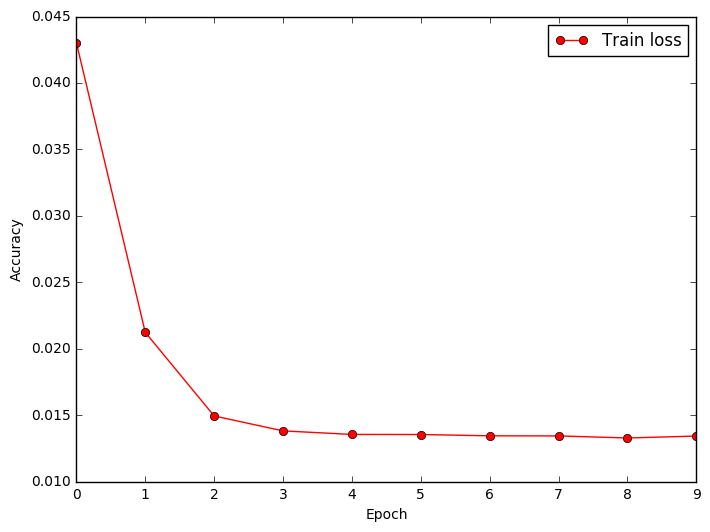

In [309]:
# Show the plot
show_plot(t_loss, None)

In [34]:
# Running Fit function with an iterator
model.fit(train_iter, test_iter, epochs=2)

Epoch 0. Loss: 0.0696829086686, Train_acc 0, Test_acc 0
Epoch 1. Loss: 0.0677475116669, Train_acc 0, Test_acc 0
